# Дмитрий Ильин
# Домашнее задание №2


# Начало

In [1]:
!pip install transformers datasets accelerate sentencepiece peft gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 

In [1]:
!pip install -i https://test.pypi.org/simple/ bitsandbytes

Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/5c/e0/597d593ec3b6cf5ea7eb4894a545045bd95611de8a316a2a1eaa838a2459/bitsandbytes-0.39.0-py3-none-any.whl (95.8 MB)


In [1]:
import os
import re
import sys
import json
import random
import pandas as pd
from tqdm import tqdm
from typing import List, Union
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

In [2]:
import torch

In [14]:
import warnings
import transformers
from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig, TrainerCallback

In [4]:
from datasets import load_dataset, load_from_disk

In [5]:
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)

In [6]:
import gradio as gr

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Параметры

In [7]:
@dataclass
class Params:
    base_model = "nickypro/tinyllama-15M"

    root_path = "/content/drive/My Drive/MIPT/NLPGen/HW2/"
    output_dir = os.path.join(root_path, "output")
    trainer_output_dir = os.path.join(root_path, "output_trainer")

    joey_csv_dataset_path = os.path.join(root_path, "joey.csv")
    dataset_path = os.path.join(root_path, "joey.json")
    dataset_tokenized_path = os.path.join(root_path, "tokenized_dataset")

    load_in_8bit = False #True
    torch_dtype =  torch.float32 #torch.float16
    device_map: str = field(init=False)
    low_cpu_mem_usage = True

    use_wandb = False

    world_size = int(os.environ.get("WORLD_SIZE", 1))
    ddp = world_size != 1

    # Гиперпараметры обучения
    batch_size: int = 128
    micro_batch_size: int = 16
    num_epochs: int = 10
    learning_rate: float = 3e-4
    cutoff_len: int = 512
    val_set_size_ratio: int = 0
    gradient_accumulation_steps: int = field(init=False)

    eval_steps: int = 100
    save_steps: int = 100
    save_total_limit: int = 10
    logging_steps: int = 10

    # Гиперпараметры Lora
    lora_r: int = 64
    lora_alpha: int = 64
    lora_dropout: float = 0.05

    # https://medium.com/@rajatsharma_33357/fine-tuning-llama-using-lora-fb3f48a557d5
    lora_target_modules: List[str] = field(default_factory=lambda: [
        "q_proj",     # Проекция запроса для механизма внимания, определяет важность ключей.
        "k_proj",     # Проекция ключа для механизма внимания, сравнивается с запросом для взвешивания.
        "v_proj",     # Проекция значения для механизма внимания, представляет данные для суммирования.
        "o_proj",     # Выходная проекция механизма внимания, суммирует взвешенные значения.
        "gate_proj",  # Модуль "ворот", контролирует поток информации внутри MLP.
        "up_proj",    # Увеличивает размерность в MLP, расширяя пространство признаков.
        "down_proj",  # Сокращает размерность после активации в MLP, возвращая к исходному размеру.
        "lm_head",    # "Голова" модели языка, генерирует распределение вероятностей токенов.
    ])


    # Гиперпараметры LLM
    train_on_inputs: bool = False  # if False, masks out inputs in loss
    group_by_length: bool = False  # faster, but produces an odd training loss curve

    # Путь к последнему чекпоинту
    def get_last_checkpoint_path(self):
        if not os.path.exists(self.output_dir):
            return None
        checkpoints = [d for d in os.listdir(self.output_dir) if d.startswith("checkpoint-")]
        if not checkpoints:
            return None
        last_checkpoint = sorted(checkpoints, reverse=True)[0]
        return os.path.join(self.output_dir, last_checkpoint)

    # Инициализация параметров
    def __post_init__(self):
        if self.ddp:
            self.device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
            self.gradient_accumulation_steps = self.gradient_accumulation_steps // self.world_size
        else:
            self.device_map = "auto"
            self.gradient_accumulation_steps = self.batch_size // self.micro_batch_size



params = Params()

# Подготовка промптера, токенизатора и датасета

Промптер

In [9]:
class Prompter(object):
    def generate_prompt(
        self,
        input: str,
        context: str,
        label: Union[None, str] = None,
    ) -> str:
        res = f"\n{input}\n"
        if context:
            res = f"{context}{res}"
        if label:
            res = f"{res}{label}"

        return res


    def get_response(self, output: str) -> str:
        return output.split('\n')[-1].strip()

prompter = Prompter()

Токенизатор

In [9]:
tokenizer = LlamaTokenizer.from_pretrained("hf-internal-testing/llama-tokenizer")

tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"  # Allow batched inference

def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=params.cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < params.cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["text"],
        data_point["previous_answer"],
        data_point["positive_answer"],
    )
    tokenized_full_prompt = tokenize(full_prompt)
    if not params.train_on_inputs:
        user_prompt = prompter.generate_prompt(
            data_point["text"],
            data_point["previous_answer"]
        )
        tokenized_user_prompt = tokenize(user_prompt, add_eos_token=False)
        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        tokenized_full_prompt["labels"] = [
            -100
        ] * user_prompt_len + tokenized_full_prompt["labels"][
            user_prompt_len:
        ]

    return tokenized_full_prompt

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Датасет

In [10]:
df = pd.read_csv(params.joey_csv_dataset_path)
df.rename(columns={"Text": "text"}, inplace=True)
df["text"] = df["text"].str.strip().str.replace(r'\(.*?\)', '', regex=True)
df["positive_answer"] = df["positive_answer"].str.strip().str.replace(r'\(.*?\)', '', regex=True)
df["previous_answer"] = df["previous_answer"].str.strip().str.replace(r'\(.*?\)', '', regex=True)
dataset = df[["text", "positive_answer", "previous_answer"]]
joey_dataset = dataset.to_dict("records")
with open(params.dataset_path, "w", encoding="utf-8") as f:
    json.dump(joey_dataset, f, ensure_ascii=False, indent=4)

In [11]:
def tokenize_dataset(raw_dataset_path, tokenized_dataset_path):
    if raw_dataset_path.endswith(".json") or raw_dataset_path.endswith(".jsonl"):
        data = load_dataset("json", data_files=raw_dataset_path)
    else:
        data = load_dataset(raw_dataset_path)

    result = data["train"].shuffle().map(generate_and_tokenize_prompt)

    if result is not None:
        result.save_to_disk(tokenized_dataset_path)

    return result

In [12]:
full_data = tokenize_dataset(params.dataset_path, params.dataset_tokenized_path)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/7865 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7865 [00:00<?, ? examples/s]

In [13]:
full_data = load_from_disk(params.dataset_tokenized_path)
if params.val_set_size_ratio > 0:
    val_set_size = round(params.val_set_size_ratio * full_data.num_rows)
    train_val = full_data.train_test_split(test_size=val_set_size, shuffle=True, seed=42)
    train_data = train_val["train"]
    val_data = train_val["test"]
else:
    train_data = full_data
    val_data = None

print(train_data)
print(val_data)

Dataset({
    features: ['text', 'positive_answer', 'previous_answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 7865
})
None


# Инициализация модели и трейнера

Модель и трейнер

In [14]:
model = LlamaForCausalLM.from_pretrained(
    pretrained_model_name_or_path=params.base_model,
    load_in_8bit=params.load_in_8bit,
    torch_dtype=params.torch_dtype,
    device_map=params.device_map,
    low_cpu_mem_usage=params.low_cpu_mem_usage,
)

config = LoraConfig(
    r=params.lora_r,
    lora_alpha=params.lora_alpha,
    target_modules=params.lora_target_modules,
    lora_dropout=params.lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

resume_from_checkpoint = None #resume_from_checkpoint = params.get_last_checkpoint_path()
if resume_from_checkpoint:
    # Check the available weights and load them
    checkpoint_name = os.path.join(
        resume_from_checkpoint, "pytorch_model.bin"
    )  # Full checkpoint
    if not os.path.exists(checkpoint_name):
        checkpoint_name = os.path.join(
            resume_from_checkpoint, "adapter_model.bin"
        )  # only LoRA model - LoRA config above has to fit
        resume_from_checkpoint = (
            False  # So the trainer won't try loading its state
        )
    # The two files above have a different name depending on how they were saved, but are actually the same.
    if os.path.exists(checkpoint_name):
        print(f"Restarting from {checkpoint_name}")
        adapters_weights = torch.load(checkpoint_name)
        model = set_peft_model_state_dict(model, adapters_weights)
    else:
        print(f"Checkpoint {checkpoint_name} not found")

model.print_trainable_parameters()

if not params.ddp and torch.cuda.device_count() > 1:
    # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
    model.is_parallelizable = True
    model.model_parallel = True

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=params.micro_batch_size,
        gradient_accumulation_steps=params.gradient_accumulation_steps,
        warmup_steps=100,
        num_train_epochs=params.num_epochs,
        learning_rate=params.learning_rate,
        fp16=(params.torch_dtype==torch.float16),
        logging_steps=params.logging_steps,
        optim="adamw_torch",
        evaluation_strategy="steps" if params.val_set_size_ratio > 0 else "no",
        save_strategy="steps",
        eval_steps=params.eval_steps if params.val_set_size_ratio > 0 else None,
        save_steps=params.save_steps,
        output_dir=params.output_dir,
        save_total_limit=params.save_total_limit,
        load_best_model_at_end=False if params.val_set_size_ratio > 0 else False,
        ddp_find_unused_parameters=False if params.ddp else None,
        group_by_length=params.group_by_length,
        report_to=None, #report_to="wandb" if params.use_wandb else None,
        run_name=None, #run_name=params.wandb_run_name if params.use_wandb else None,
        push_to_hub=False,
        do_train=True,
        do_eval=(params.val_set_size_ratio > 0),
    ),
    data_collator=transformers.DataCollatorForSeq2Seq(
        tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    ),
)

model.config.use_cache = False

if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)

trainer.model

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('https'), PosixPath('//colab\\.(sandbox|research)\\.google\\.com')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/env/python')}
  wa

trainable params: 4,167,680 || all params: 19,359,392 || trainable%: 21.52794881161557


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 288)
        (layers): ModuleList(
          (0-5): 6 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=288, out_features=288, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=288, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=288, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=288, out_fe

In [15]:
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.loss = []
        self.learning_rate = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.loss.append(logs["loss"])
            if "learning_rate" in logs:
                self.learning_rate.append(logs["learning_rate"])

loss_logging_callback = LossLoggingCallback()
trainer.add_callback(loss_logging_callback)

# Обучение

In [16]:
trainer.train() #resume_from_checkpoint=params.get_last_checkpoint_path())
trainer.save_model(params.output_dir)
#trainer.model.save_pretrained(params.trainer_output_dir)

Step,Training Loss
10,5.702000
20,5.159400
30,4.809000
40,4.602000
50,4.272400
60,3.996900
70,3.589500
80,3.587200
90,3.580700
100,3.552800


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

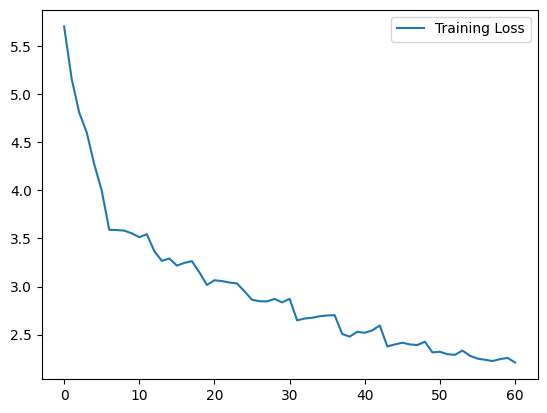

In [17]:
plt.plot(loss_logging_callback.loss, label="Training Loss")
plt.legend()
plt.show()

# 3. Использование модели

In [12]:
prompter = Prompter()

tokenizer = LlamaTokenizer.from_pretrained("hf-internal-testing/llama-tokenizer")

joey_model = LlamaForCausalLM.from_pretrained(
    pretrained_model_name_or_path=params.base_model,
    load_in_8bit=params.load_in_8bit,
    torch_dtype=params.torch_dtype,
    device_map=params.device_map,
    low_cpu_mem_usage=params.low_cpu_mem_usage,
)
joey_model = PeftModel.from_pretrained(
    joey_model,
    params.output_dir,
    torch_dtype=params.torch_dtype,
    device_map={'': 0},
)
joey_model.eval()
if torch.__version__ >= "2" and sys.platform != "win32":
    joey_model = torch.compile(joey_model)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab\\.(sandbox|research)\\.google\\.com'), PosixPath('https')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/env/python')}
  wa

In [10]:
device="cuda"

def generate_reply(
    model,
    text,
    context,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=512,
    **kwargs,
):
    prompt = prompter.generate_prompt(text, context)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )

    generate_params = {
        "input_ids": input_ids,
        "generation_config": generation_config,
        "return_dict_in_generate": True,
        "output_scores": True,
        "max_new_tokens": max_new_tokens,
    }

    # Без стриминга инференса
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s, skip_special_tokens=True).strip()

    return prompter.get_response(output)


def get_reply(model, text, context=None):
    inference = generate_reply(model, text, context)

    return inference

In [20]:
#joey_model = model

In [15]:
warnings.filterwarnings("ignore")

In [16]:
print(get_reply(joey_model, "Let's order a delivery!", "I want pizza"))

I don't know what's a delivery is, but I don't think it's anything wrong.


In [17]:
print(get_reply(joey_model, "She is my sister!", "I like her!"))

Yeah, she is my sister's sister.


In [18]:
print(get_reply(joey_model, "Let's not drink that much beer next time.", "I was so drunk last night."))

Yeah, I'm sorry.


# Тест чата в Gradio

In [33]:
def talk_to_joey(message, history):
    if len(history) > 0:
        return get_reply(joey_model, message, history[-1][1])
    else:
        return get_reply(joey_model, message)

iface = gr.ChatInterface(talk_to_joey)
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eef421a2eae36155d5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [34]:
iface.close()

Closing server running on port: 7862


# Выводы

Добработка с помощью Lora даже такой небольшой языковой модели как tinyllama c 15 миллионами параметров позволила добиться относительно неплохих результатов.
Однако из-за природы датасета, который представляет из себя сценарий ситкома с ограниченным набором реплик, полностью "человеческого" диалога тут ждать не стоит. Очень интересно будет попробовать такой подход, но на большом датасете из диалогов реальных людей.